In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import nltk


from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('claims_test.csv', sep=',')
print(df.shape)
df.head()

(52152, 5)


,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,128438
1,201801,AncillaryFFS,NaN,Payer H,66624
2,201801,AncillaryFFS,NaN,Payer O,118108
3,201801,AncillaryFFS,NaN,Payer W,1073
4,201801,AncillaryFFS,ACH,Payer W,604


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


### MONTH

In [4]:
df['MONTH'].value_counts(dropna=False)

201907    1877
201910    1863
201908    1828
201905    1823
201901    1790
202001    1782
201808    1775
201909    1774
201912    1772
202003    1769
201903    1769
201904    1767
201809    1767
201805    1759
201902    1751
201810    1748
201811    1747
201906    1746
201806    1745
201803    1723
201911    1723
201812    1718
201804    1714
201801    1712
202002    1711
201807    1706
202005    1668
201802    1664
202004    1539
202006    1344
202007      67
201900      11
Name: MONTH, dtype: int64

In [5]:
# Уберем косячный месяц и июль 20-го.
df = df[(df['MONTH'] != 202007) & (df['MONTH'] != 201900)]

In [6]:
df['MONTH'] = pd.DatetimeIndex(df['MONTH'].map(lambda x: str(x) + '01'))
df['MONTH'].value_counts()

2019-07-01    1877
2019-10-01    1863
2019-08-01    1828
2019-05-01    1823
2019-01-01    1790
2020-01-01    1782
2018-08-01    1775
2019-09-01    1774
2019-12-01    1772
2020-03-01    1769
2019-03-01    1769
2018-09-01    1767
2019-04-01    1767
2018-05-01    1759
2019-02-01    1751
2018-10-01    1748
2018-11-01    1747
2019-06-01    1746
2018-06-01    1745
2019-11-01    1723
2018-03-01    1723
2018-12-01    1718
2018-04-01    1714
2018-01-01    1712
2020-02-01    1711
2018-07-01    1706
2020-05-01    1668
2018-02-01    1664
2020-04-01    1539
2020-06-01    1344
Name: MONTH, dtype: int64

### SERVICE_CATEGORY

In [7]:
df['SERVICE_CATEGORY'].value_counts(dropna=False)

SpecialistsFFS        12275
AncillaryFFS           9682
InpatientServices      9413
OutpatientServices     7572
ERServices             3690
ASCServices            2639
SNFServices            2497
SpecialistFFS          1684
PCPFFS                 1401
PCPEncounter           1221
Name: SERVICE_CATEGORY, dtype: int64

### CLAIM_SPECIALITY

In [8]:
df['CLAIM_SPECIALTY'].value_counts(dropna=False)

INTERNAL MEDICINE        1227
FAMILY PRACTICE          1128
GENERAL PRACTICE          949
GENERAL SURGERY           806
PATHOLOGY                 772
                         ... 
NPGYNO                      1
OTORHI                      1
MDWIFE                      1
Hyper Baric Treatment       1
Neonatology                 1
Name: CLAIM_SPECIALTY, Length: 906, dtype: int64

In [11]:
# Разобьем текст на слова и приведем их в начальную форму.
def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

lemmatizer = nltk.WordNetLemmatizer()

text = list(df['CLAIM_SPECIALTY'].fillna('delete').apply(lambda x: 
                                                        list(
                                                            filter(
                                                                lambda i: len(i) > 1, 
                                                                [lemmatizer.lemmatize(w, get_wordnet_pos(w)).lower() for w in nltk.word_tokenize(x)]
                                                            ))))
text

[['delete'],
 ['delete'],
 ['delete'],
 ['delete'],
 ['ach'],
 ['advanced', 'registered', 'nurse', 'prac'],
 ['advanced', 'rn', 'pract'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance', 'service'],
 ['ambulatory', 'surgical', 'center'],
 ['ambulatory', 'transportation', 'services'],
 ['anatom'],
 ['anesthesiology'],
 ['arnp'],
 ['behavioral', 'health', 'counseling'],
 ['card', 'electrophysiolo'],
 ['cardiac', 'electrophysiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology/cardiovascular', 'disease'],
 ['cardiovascular', 'medicine'],
 ['cardiovascular', 'surgery'],
 ['ccs'],
 ['chiropractic', 'medicine'],
 ['clinical', 'medical', 'laboratory'],
 ['colon', 'and', 'rectal', 'surgery'],
 ['community', 'mental', 'health', 'center'],
 ['community', 'mental', 'health', 'center/other', 'rehab', 'center'],
 ['conv', 'care', 'clinic'],
 ['covering', 'physician']

In [12]:
len(text)

52074

In [13]:
# Посчитаем слова, которые встречались как минимум в 100 записях.
vectorizer = CountVectorizer(min_df=100)
matrix = vectorizer.fit_transform([' '.join(i) for i in text])

In [14]:
len(vectorizer.get_feature_names())

147

In [15]:
words = vectorizer.get_feature_names()
words

['acute',
 'advanced',
 'agency',
 'allergy',
 'ambulance',
 'ambulatory',
 'anatomic',
 'and',
 'anesthesiologist',
 'anesthesiology',
 'anesthetist',
 'arnp',
 'assistant',
 'card',
 'cardiac',
 'cardiology',
 'cardiothoracic',
 'cardiovascular',
 'care',
 'center',
 'certified',
 'chiropractic',
 'clinic',
 'clinical',
 'colon',
 'colorectal',
 'covering',
 'critical',
 'delete',
 'dermatology',
 'dermatopathology',
 'diag',
 'diagnostic',
 'dialysis',
 'disease',
 'diseases',
 'dme',
 'doctor',
 'durable',
 'electrophysiolo',
 'electrophysiology',
 'emergency',
 'endocrinology',
 'ent',
 'equipment',
 'facility',
 'family',
 'gastroenterology',
 'general',
 'geriatrics',
 'gynecologic',
 'gynecology',
 'hand',
 'health',
 'hematology',
 'home',
 'hospice',
 'hospital',
 'hospitalist',
 'imaging',
 'immunology',
 'independent',
 'infectious',
 'infusion',
 'internal',
 'interventional',
 'lab',
 'laboratory',
 'management',
 'med',
 'medical',
 'medicine',
 'mental',
 'nephrology',


In [16]:
# Список осмысленных слов
cool_words = [
 'allergy',
 'ambulance',
 'ambulatory',
 'anatomic',
 'anesthesiologist',
 'anesthesiology',
 'anesthetist',
 'card',
 'cardiology',
 'cardiothoracic',
 'cardiovascular',
 'chiropractic',
 'colon',
 'colorectal',
 'critical',
 'dermatology',
 'dermatopathology',
 'diag',
 'diagnostic',
 'dialysis',
 'electrophysiolo',
 'electrophysiology',
 'emergency',
 'endocrinology',
 'family',
 'gastroenterology',
 'gynecologic',
 'gynecology',
 'hematology',
 'immunology',
 'infectious',
 'infusion',
 'interventional',
 'lab',
 'laboratory',
 'mental',
 'nephrology',
 'neurological',
 'neurology',
 'neuroradiology',
 'neurosurgery',
 'nuclear',
 'nurse',
 'nursing',
 'obstetrics',
 'occupational',
 'oncology',
 'ophthalmology',
 'opthalmology',
 'optometry',
 'orthopedic',
 'orthotics',
 'osteopath',
 'otolaryngology',
 'palliative',
 'pathology',
 'pediatric',
 'pediatrics',
 'phys',
 'physical',
 'physician',
 'plastic',
 'podiatrist',
 'podiatry',
 'prosthetics',
 'psych',
 'psychiatry',
 'psychologist',
 'psychology',
 'pulmonary',
 'pulmonology',
 'radiation',
 'radiol',
 'radiology',
 'rectal',
 'rehab',
 'rehabilitation',
 'rheumatology',
 'sports',
 'surgery',
 'surgical',
 'therapist',
 'therapy',
 'thoracic',
 'urology',
 'vascular',
 'vision']

In [17]:
# Список групп слов. 
groups = [
  
 ['anesthesiology',
  'anesthesiologist',
 'anesthetist'],
 
 ['cardiology',
  'card'],
 
 [
 'diagnostic',
     'diag'],
 
 ['electrophysiology',
     'electrophysiolo'
 ],
 
 ['gynecology',
  'gynecologic'],
 
 
 ['laboratory','lab'],
 
 ['neurology', 'nephrology',
 'neurological'],
 
 ['nurse',
 'nursing'],
 
 ['ophthalmology',
 'opthalmology'],
 
 ['pediatric',
 'pediatrics', 'podiatrist',
 'podiatry',],
 
 ['physical',
    'phys',
 'physician'],
['psychiatry',
 'psych'],
 
 [
 'psychology',
     'psychologist'],

    ['radiology',
 'radiation',
 'radiol'],
 

 ['rehab',
 'rehabilitation'],

 ['surgery',
 'surgical'],
 ['therapy', 'therapist']]

In [18]:
# Делаем словарь. 
# Сперва пробежимся по группам. Нулевой элемент грппы - значение, все остальные - ключи.
map_dict = dict()
for group in groups:
    value = group[0]
    for key in group[1:]:
        map_dict[key] = value
        
# Остальные слова. Если слово уже в словаре, следующая итерация. 
# Если слово осмысленное, оставляем значение, иначе - присваиваем значение 'delete'.
for word in words:
    if word in map_dict:
        continue
    if word in cool_words:
        map_dict[word] = word
    else:
        map_dict[word] = 'delete'
map_dict

{'anesthesiologist': 'anesthesiology',
 'anesthetist': 'anesthesiology',
 'card': 'cardiology',
 'diag': 'diagnostic',
 'electrophysiolo': 'electrophysiology',
 'gynecologic': 'gynecology',
 'lab': 'laboratory',
 'nephrology': 'neurology',
 'neurological': 'neurology',
 'nursing': 'nurse',
 'opthalmology': 'ophthalmology',
 'pediatrics': 'pediatric',
 'podiatrist': 'pediatric',
 'podiatry': 'pediatric',
 'phys': 'physical',
 'physician': 'physical',
 'psych': 'psychiatry',
 'psychologist': 'psychology',
 'radiation': 'radiology',
 'radiol': 'radiology',
 'rehabilitation': 'rehab',
 'surgical': 'surgery',
 'therapist': 'therapy',
 'acute': 'delete',
 'advanced': 'delete',
 'agency': 'delete',
 'allergy': 'allergy',
 'ambulance': 'ambulance',
 'ambulatory': 'ambulatory',
 'anatomic': 'anatomic',
 'and': 'delete',
 'anesthesiology': 'anesthesiology',
 'arnp': 'delete',
 'assistant': 'delete',
 'cardiac': 'delete',
 'cardiology': 'cardiology',
 'cardiothoracic': 'cardiothoracic',
 'cardiov

In [19]:
# Преобразуем значения в тексте. Если слова нет в map_dict, заменяем его на 'delete'.
text = [list(map(lambda x: map_dict[x] if x in map_dict else 'delete', row)) for row in text]
text

[['delete'],
 ['delete'],
 ['delete'],
 ['delete'],
 ['delete'],
 ['delete', 'delete', 'nurse', 'delete'],
 ['delete', 'delete', 'delete'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance', 'delete'],
 ['ambulatory', 'surgery', 'delete'],
 ['ambulatory', 'delete', 'delete'],
 ['delete'],
 ['anesthesiology'],
 ['delete'],
 ['delete', 'delete', 'delete'],
 ['cardiology', 'electrophysiology'],
 ['delete', 'electrophysiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['delete', 'delete'],
 ['cardiovascular', 'delete'],
 ['cardiovascular', 'surgery'],
 ['delete'],
 ['chiropractic', 'delete'],
 ['delete', 'delete', 'laboratory'],
 ['colon', 'delete', 'rectal', 'surgery'],
 ['delete', 'mental', 'delete', 'delete'],
 ['delete', 'mental', 'delete', 'delete', 'rehab', 'delete'],
 ['delete', 'delete', 'delete'],
 ['delete', 'physical'],
 ['critical', 'delete'],
 ['delete'],
 

In [20]:
# Удаляем дубликаты и значения 'delete' если они есть.
text = [list(filter(lambda x: x != 'delete', list(set(row)))) for row in text]
text

[[],
 [],
 [],
 [],
 [],
 ['nurse'],
 [],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulance'],
 ['ambulatory', 'surgery'],
 ['ambulatory'],
 [],
 ['anesthesiology'],
 [],
 [],
 ['cardiology', 'electrophysiology'],
 ['electrophysiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 ['cardiology'],
 [],
 ['cardiovascular'],
 ['surgery', 'cardiovascular'],
 [],
 ['chiropractic'],
 ['laboratory'],
 ['colon', 'surgery', 'rectal'],
 ['mental'],
 ['mental', 'rehab'],
 [],
 ['physical'],
 ['critical'],
 [],
 [],
 [],
 ['dermatology'],
 ['dermatology'],
 ['dermatology'],
 ['dermatology'],
 ['dermatology'],
 ['dermatopathology'],
 ['dermatopathology'],
 [],
 ['diagnostic'],
 ['diagnostic', 'radiology'],
 ['diagnostic', 'radiology'],
 [],
 [],
 ['dialysis'],
 ['dialysis'],
 ['dialysis'],
 ['dialysis'],
 [],
 [],
 ['psychology'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['emergency'],
 ['emergency'],
 ['emerg

In [21]:
df['CLAIM_SPECIALTY'] = pd.Series([' '.join(i) for i in text]).apply(lambda x: np.nan if x=='' else x)
df.head(30)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,2018-01-01,AncillaryFFS,NaN,Payer F,128438
1,2018-01-01,AncillaryFFS,NaN,Payer H,66624
2,2018-01-01,AncillaryFFS,NaN,Payer O,118108
3,2018-01-01,AncillaryFFS,NaN,Payer W,1073
4,2018-01-01,AncillaryFFS,NaN,Payer W,604
5,2018-01-01,AncillaryFFS,nurse,Payer UN,0
6,2018-01-01,AncillaryFFS,NaN,Payer CA,1772
7,2018-01-01,AncillaryFFS,ambulance,Payer CA,446698
8,2018-01-01,AncillaryFFS,ambulance,Payer CO,51664
9,2018-01-01,AncillaryFFS,ambulance,Payer F,1083232


### PAYER

In [22]:
df['PAYER'].value_counts(dropna=False)

Payer F     9012
Payer CA    8681
Payer W     7105
Payer UN    6526
Payer O     6277
Payer S     4189
Payer CO    3677
Payer B     3631
Payer H     2291
Payer UL     685
Name: PAYER, dtype: int64

### AMOUNT

In [23]:
df['PAID_AMOUNT'].describe()

count    5.207400e+04
mean     1.016419e+05
std      1.036455e+06
min     -1.689190e+05
25%      7.750000e+02
50%      3.730000e+03
75%      2.041050e+04
max      6.805834e+07
Name: PAID_AMOUNT, dtype: float64

In [24]:
# Кол-во платежей меньше 0.
(df['PAID_AMOUNT'] < 0).sum()

318

In [25]:
# Кол-во платежей равно 0.
(df['PAID_AMOUNT'] == 0).sum()

3844

In [26]:
df['err'] = (df['PAID_AMOUNT'] < 0).astype(int)

In [27]:
df.groupby(by=['SERVICE_CATEGORY', 'err'])[['err']].count()

err
SERVICE_CATEGORY   err       
ASCServices        0     2639
AncillaryFFS       0     9446
                   1      236
ERServices         0     3690
InpatientServices  0     9413
OutpatientServices 0     7572
PCPEncounter       0     1139
                   1       82
PCPFFS             0     1401
SNFServices        0     2497
SpecialistFFS      0     1684
SpecialistsFFS     0    12275

In [28]:
df.groupby(by=['PAYER', 'err'])[['err']].count()

err
PAYER    err      
Payer B  0    3625
         1       6
Payer CA 0    8598
         1      83
Payer CO 0    3676
         1       1
Payer F  0    9012
Payer H  0    2288
         1       3
Payer O  0    6277
Payer S  0    4189
Payer UL 0     685
Payer UN 0    6303
         1     223
Payer W  0    7103
         1       2

In [29]:
df.drop(columns=['err'], inplace=True)

В задании поле описано как "затраты", поэтому значения < 0 считал ошибочными.
У записей с PAID_AMOUNT < 0 я считал ошибочным только поле платежа, удалять строки не стал.
Возможно минус пришел из текста.
Заменил значения на 0.

In [30]:
df['PAID_AMOUNT'] = df['PAID_AMOUNT'].apply(lambda x: max(0, x))

/home/artem/novapulsar_task/application/novapulsar_task_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PAID_AMOUNT'>

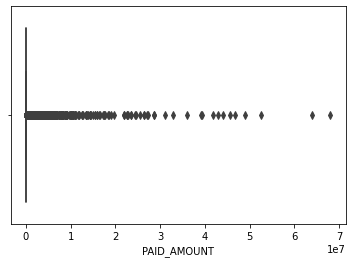

In [31]:
sns.boxplot(df['PAID_AMOUNT'])

### to csv

In [32]:
df.head(10)

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,2018-01-01,AncillaryFFS,NaN,Payer F,128438
1,2018-01-01,AncillaryFFS,NaN,Payer H,66624
2,2018-01-01,AncillaryFFS,NaN,Payer O,118108
3,2018-01-01,AncillaryFFS,NaN,Payer W,1073
4,2018-01-01,AncillaryFFS,NaN,Payer W,604
5,2018-01-01,AncillaryFFS,nurse,Payer UN,0
6,2018-01-01,AncillaryFFS,NaN,Payer CA,1772
7,2018-01-01,AncillaryFFS,ambulance,Payer CA,446698
8,2018-01-01,AncillaryFFS,ambulance,Payer CO,51664
9,2018-01-01,AncillaryFFS,ambulance,Payer F,1083232


In [34]:
df.to_csv('application/data/df.csv', sep=',', index=False)

#  TRASH

In [21]:
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('application/data/df.csv', sep=',')
print(df.shape)
df.head()

(52074, 5)


,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,2018-01-01,AncillaryFFS,NaN,Payer F,128438
1,2018-01-01,AncillaryFFS,NaN,Payer H,66624
2,2018-01-01,AncillaryFFS,NaN,Payer O,118108
3,2018-01-01,AncillaryFFS,NaN,Payer W,1073
4,2018-01-01,AncillaryFFS,NaN,Payer W,604


In [9]:
pd.to_datetime(df['MONTH']).max()

Timestamp('2020-06-01 00:00:00')

In [10]:
df['MONTH'] = pd.to_datetime(df['MONTH'])

In [11]:
df['MONTH'].unique()

array(['2018-01-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-08-01T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01

In [18]:
df['MONTH'].value_counts()

2019-07-01    1877
2019-10-01    1863
2019-08-01    1828
2019-05-01    1823
2019-01-01    1790
2020-01-01    1782
2018-08-01    1775
2019-09-01    1774
2019-12-01    1772
2020-03-01    1769
2019-03-01    1769
2018-09-01    1767
2019-04-01    1767
2018-05-01    1759
2019-02-01    1751
2018-10-01    1748
2018-11-01    1747
2019-06-01    1746
2018-06-01    1745
2019-11-01    1723
2018-03-01    1723
2018-12-01    1718
2018-04-01    1714
2018-01-01    1712
2020-02-01    1711
2018-07-01    1706
2020-05-01    1668
2018-02-01    1664
2020-04-01    1539
2020-06-01    1344
Name: MONTH, dtype: int64

In [56]:
df['MONTH'].dt.strftime('%b %Y')

0        Jan 2018
1        Jan 2018
2        Jan 2018
3        Jan 2018
4        Jan 2018
           ...   
52069    Jun 2020
52070    Jun 2020
52071    Jun 2020
52072    Jun 2020
52073    Jun 2020
Name: MONTH, Length: 52074, dtype: object

In [95]:
months = pd.Series(df['MONTH'].unique())
months

0    2018-01-01
1    2018-02-01
2    2018-03-01
3    2018-04-01
4    2018-05-01
5    2018-06-01
6    2018-07-01
7    2018-08-01
8    2018-09-01
9    2018-10-01
10   2018-11-01
11   2018-12-01
12   2019-01-01
13   2019-02-01
14   2019-03-01
15   2019-04-01
16   2019-05-01
17   2019-06-01
18   2019-07-01
19   2019-08-01
20   2019-09-01
21   2019-10-01
22   2019-11-01
23   2019-12-01
24   2020-01-01
25   2020-02-01
26   2020-03-01
27   2020-04-01
28   2020-05-01
29   2020-06-01
dtype: datetime64[ns]

In [96]:
months[0]

Timestamp('2018-01-01 00:00:00')

In [100]:
months = pd.Series(df['MONTH'].unique())
months = dict((i, {'timestamp': months[i], 'string': months[i].strftime('%b %Y')}) for i in months.index)
months

{0: {'timestamp': Timestamp('2018-01-01 00:00:00'), 'string': 'Jan 2018'},
 1: {'timestamp': Timestamp('2018-02-01 00:00:00'), 'string': 'Feb 2018'},
 2: {'timestamp': Timestamp('2018-03-01 00:00:00'), 'string': 'Mar 2018'},
 3: {'timestamp': Timestamp('2018-04-01 00:00:00'), 'string': 'Apr 2018'},
 4: {'timestamp': Timestamp('2018-05-01 00:00:00'), 'string': 'May 2018'},
 5: {'timestamp': Timestamp('2018-06-01 00:00:00'), 'string': 'Jun 2018'},
 6: {'timestamp': Timestamp('2018-07-01 00:00:00'), 'string': 'Jul 2018'},
 7: {'timestamp': Timestamp('2018-08-01 00:00:00'), 'string': 'Aug 2018'},
 8: {'timestamp': Timestamp('2018-09-01 00:00:00'), 'string': 'Sep 2018'},
 9: {'timestamp': Timestamp('2018-10-01 00:00:00'), 'string': 'Oct 2018'},
 10: {'timestamp': Timestamp('2018-11-01 00:00:00'), 'string': 'Nov 2018'},
 11: {'timestamp': Timestamp('2018-12-01 00:00:00'), 'string': 'Dec 2018'},
 12: {'timestamp': Timestamp('2019-01-01 00:00:00'), 'string': 'Jan 2019'},
 13: {'timestamp': Tim

In [92]:
min(months_dict.keys())

0

In [76]:
dict((i, months_dict[i].strftime('%b %Y')) for i in months_dict)

{0: 'Jan 2018',
 1: 'Feb 2018',
 2: 'Mar 2018',
 3: 'Apr 2018',
 4: 'May 2018',
 5: 'Jun 2018',
 6: 'Jul 2018',
 7: 'Aug 2018',
 8: 'Sep 2018',
 9: 'Oct 2018',
 10: 'Nov 2018',
 11: 'Dec 2018',
 12: 'Jan 2019',
 13: 'Feb 2019',
 14: 'Mar 2019',
 15: 'Apr 2019',
 16: 'May 2019',
 17: 'Jun 2019',
 18: 'Jul 2019',
 19: 'Aug 2019',
 20: 'Sep 2019',
 21: 'Oct 2019',
 22: 'Nov 2019',
 23: 'Dec 2019',
 24: 'Jan 2020',
 25: 'Feb 2020',
 26: 'Mar 2020',
 27: 'Apr 2020',
 28: 'May 2020',
 29: 'Jun 2020'}

In [63]:
dict((i, i.strftime('%b %Y')) for i in pd.Series(df['MONTH'].unique()))

{Timestamp('2018-01-01 00:00:00'): 'Jan 2018',
 Timestamp('2018-02-01 00:00:00'): 'Feb 2018',
 Timestamp('2018-03-01 00:00:00'): 'Mar 2018',
 Timestamp('2018-04-01 00:00:00'): 'Apr 2018',
 Timestamp('2018-05-01 00:00:00'): 'May 2018',
 Timestamp('2018-06-01 00:00:00'): 'Jun 2018',
 Timestamp('2018-07-01 00:00:00'): 'Jul 2018',
 Timestamp('2018-08-01 00:00:00'): 'Aug 2018',
 Timestamp('2018-09-01 00:00:00'): 'Sep 2018',
 Timestamp('2018-10-01 00:00:00'): 'Oct 2018',
 Timestamp('2018-11-01 00:00:00'): 'Nov 2018',
 Timestamp('2018-12-01 00:00:00'): 'Dec 2018',
 Timestamp('2019-01-01 00:00:00'): 'Jan 2019',
 Timestamp('2019-02-01 00:00:00'): 'Feb 2019',
 Timestamp('2019-03-01 00:00:00'): 'Mar 2019',
 Timestamp('2019-04-01 00:00:00'): 'Apr 2019',
 Timestamp('2019-05-01 00:00:00'): 'May 2019',
 Timestamp('2019-06-01 00:00:00'): 'Jun 2019',
 Timestamp('2019-07-01 00:00:00'): 'Jul 2019',
 Timestamp('2019-08-01 00:00:00'): 'Aug 2019',
 Timestamp('2019-09-01 00:00:00'): 'Sep 2019',
 Timestamp('2

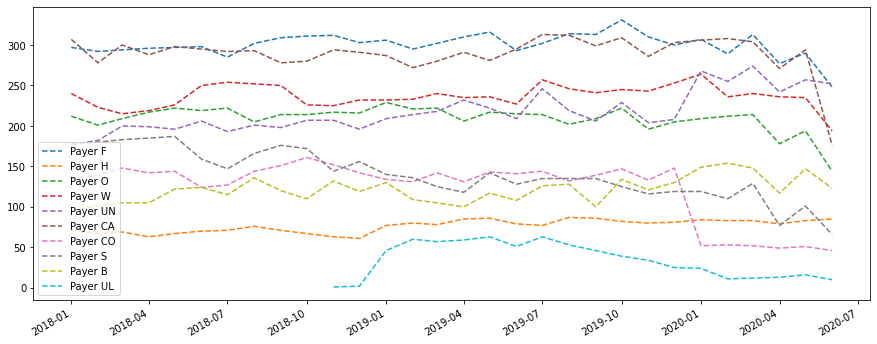

In [32]:
ax, fig = plt.subplots(figsize=(15, 6))

#df['MONTH'].value_counts().plot(label = 'ALL')
for i in df['PAYER'].unique():
    df[df['PAYER'] == i]['MONTH'].value_counts().plot(label=i, linestyle = '--')
plt.legend()
plt.show()

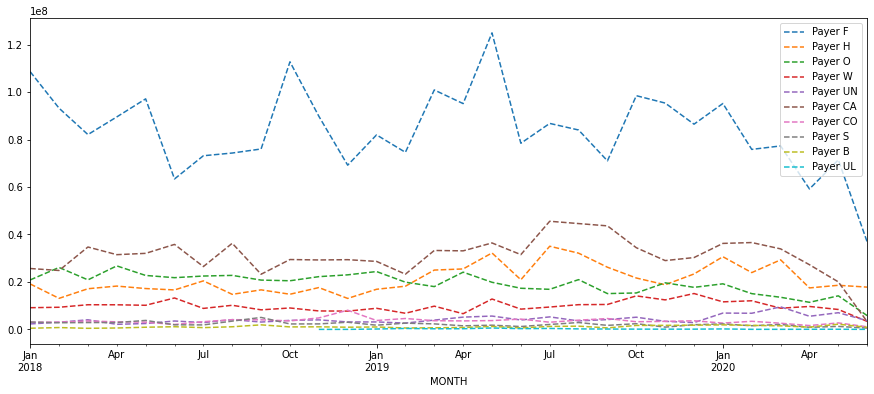

In [44]:
#df[['MONTH', 'PAID_AMOUNT']].groupby('MONTH').sum().plot()

ax, fig = plt.subplots(figsize=(15, 6))

#df[['MONTH', 'PAID_AMOUNT']].groupby('MONTH').sum()['PAID_AMOUNT'].plot(label = 'ALL')
for i in df['PAYER'].unique():
    f_df = df[df['PAYER'] == i]
    f_df[['MONTH', 'PAID_AMOUNT']].groupby('MONTH').sum()['PAID_AMOUNT'].plot(label=i, linestyle = '--')
plt.legend()
plt.show()

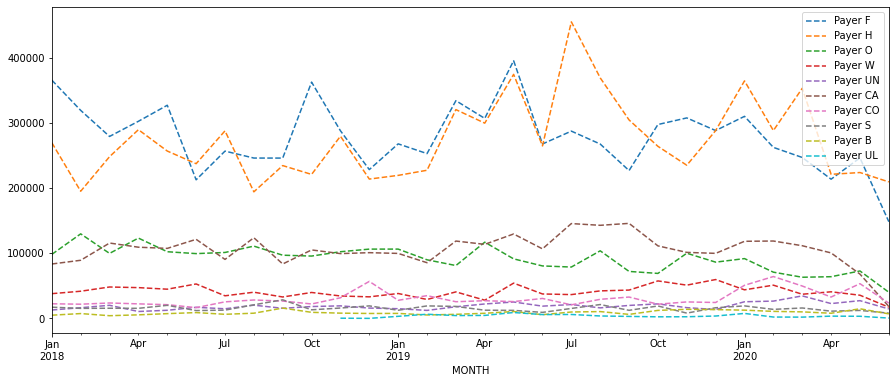

In [45]:
#df[['MONTH', 'PAID_AMOUNT']].groupby('MONTH').sum().plot()

ax, fig = plt.subplots(figsize=(15, 6))

#df[['MONTH', 'PAID_AMOUNT']].groupby('MONTH').sum()['PAID_AMOUNT'].plot(label = 'ALL')
for i in df['PAYER'].unique():
    f_df = df[df['PAYER'] == i]
    f_df[['MONTH', 'PAID_AMOUNT']].groupby('MONTH').mean()['PAID_AMOUNT'].plot(label=i, linestyle = '--')
plt.legend()
plt.show()

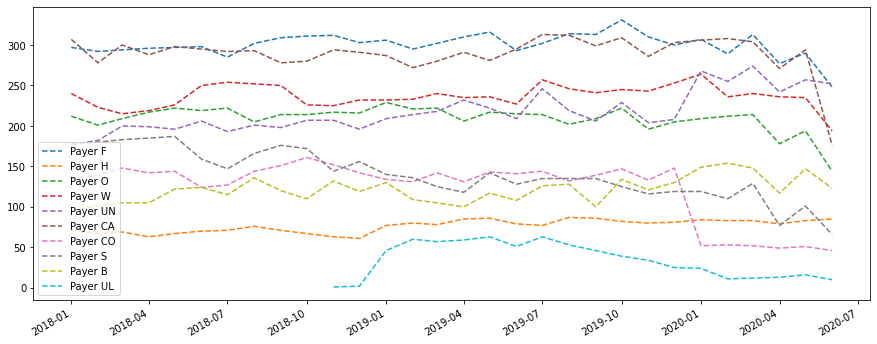

In [32]:
ax, fig = plt.subplots(figsize=(15, 6))

#df['MONTH'].value_counts().plot(label = 'ALL')
for i in df['PAYER'].unique():
    df[df['PAYER'] == i]['MONTH'].value_counts().plot(label=i, linestyle = '--')
plt.legend()
plt.show()

In [ ]:
df['']